In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Perform exploratory data analysis

In [6]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [7]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

total_duplicate_titles = sum(arxiv_data['titles'].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

# drop duplicatation
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]

print(f"There are {sum(arxiv_data['terms'].value_counts() == 1)} labels with occurrence as low as 1")

print(f"Number of unique terms: {arxiv_data['terms'].nunique()}")

There are 51774 rows in the dataset.
There are 12802 duplicate titles.
There are 2321 labels with occurrence as low as 1
Number of unique terms: 3157


In [8]:
arxiv_data_filtered  = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

Convert the string labels to lists of strings

In [10]:
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

Use stratified splits because of class imbalance

In [11]:
test_split = 0.1

train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered['terms'].values,
)

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Multi-label binarization

Now we preprocess our labels using the StringLookup layer.

In [14]:
terms = tf.ragged.constant(train_df['terms'].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print(f"Vocabulary: {vocab}")

Vocabulary: ['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.NI', 'cs.SE', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'I.2.10', 'cs.CE', 'cs.AR', 'q-fin.ST', 'cond-mat.stat-mech', '68T05', 'math.DS', 'cs.CC', 'quant-ph', 'physics.data-an', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'q-bio.GN', 'econ.EM', 'cs.DM', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'hep-ex', '68T10', 'physics.optics', 'physics.geo-ph', 'cond-mat.mtrl-sci', 'physics.flu-dyn', 'math.CO', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', 'I.

In [16]:
sample_label = train_df['terms'].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Binarized label: {label_binarized}")

Original label: ['cs.CV', 'cs.AI']
Binarized label: [[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Data preprocessing and tf.data.Dataset objects

In [17]:
# get % esimates of the seq length
train_df['summaries'].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.529119
std         41.550223
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

In [30]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def unify_text_length(text, label):
    # Split the given abstract and calculate its length.
    word_splits = tf.strings.split(text, sep=" ")
    sequence_length = tf.shape(word_splits)[0]

    # Calculate the padding amount.
    padding_amount = max_seqlen - sequence_length

    # Check if we need to pad or truncate.
    if padding_amount > 0:
        unified_text = tf.pad([text], [[0, padding_amount]], constant_values="<pad>")
        unified_text = tf.strings.reduce_join(unified_text, separator="")
    else:
        unified_text = tf.strings.reduce_join(word_splits[:max_seqlen], separator=" ")

    # The expansion is needed for subsequent vectorization.
    return tf.expand_dims(unified_text, -1), label


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    dataset = dataset.map(unify_text_length, num_parallel_calls=auto).cache()
    return dataset.batch(batch_size)

In [31]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [32]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Domain adaptation aims to learn a transferable model to bridge the domain\nshift between one labeled source domain and another sparsely labeled or\nunlabeled target domain. Since the labeled data may be collected from multiple\nsources, multi-source domain adaptation (MDA) has attracted increasing\nattention. Recent MDA methods do not consider the pixel-level alignment between\nsources and target or the misalignment across different sources. In this paper,\nwe propose a novel MDA framework to address these challenges. Specifically, we\ndesign an end-to-end Multi-source Adversarial Domain Aggregation Network\n(MADAN). First, an adapted domain is generated for each source with dynamic\nsemantic consistency while aligning towards the target at the pixel-level\ncycle-consistently. Second, sub-domain aggregation discriminator and\ncross-domain cycle discriminator are proposed to make different adapted domains\nmore closely aggregated. Finally, feature-level alignment is performe

Vectorization

In [34]:
train_df["total_words"] = train_df["summaries"].str.split().str.len()
vocabulary_size = train_df["total_words"].max()
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

Create a text classification model

In [36]:
def make_model():
   shallow_mlp_model = keras.Sequential(
       [
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
       ]
   )
   return shallow_mlp_model

Train the model


Epoch 1/20
258/258 [==============================] - 6s 20ms/step - loss: 0.0660 - categorical_accuracy: 0.7715 - val_loss: 0.0219 - val_categorical_accuracy: 0.8576
Epoch 2/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0222 - categorical_accuracy: 0.8677 - val_loss: 0.0205 - val_categorical_accuracy: 0.8696
Epoch 3/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0213 - categorical_accuracy: 0.8711 - val_loss: 0.0199 - val_categorical_accuracy: 0.8778
Epoch 4/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0206 - categorical_accuracy: 0.8761 - val_loss: 0.0195 - val_categorical_accuracy: 0.8783
Epoch 5/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0201 - categorical_accuracy: 0.8807 - val_loss: 0.0193 - val_categorical_accuracy: 0.8811
Epoch 6/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0197 - categorical_accuracy: 0.8846 - val_loss: 0.0190 - val_categorical_accuracy: 0.889

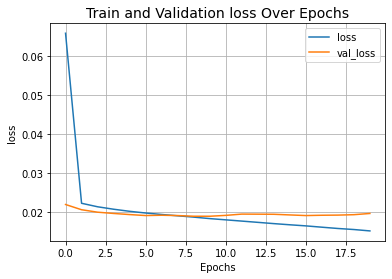

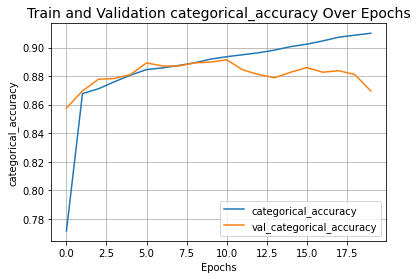

In [43]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

Evaluate the model

In [44]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc*100, 2)}%.")

15/15 [==============================] - 1s 28ms/step - loss: 0.0205 - categorical_accuracy: 0.8565
Categorical accuracy on the test set: 85.65%.


In [40]:
a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (128, 512)                255488    
_________________________________________________________________
dense_4 (Dense)              (128, 256)                131328    
_________________________________________________________________
dense_5 (Dense)              (128, 153)                39321     
Total params: 426,137
Trainable params: 426,137
Non-trainable params: 0
_________________________________________________________________


Inference

In [45]:
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")

    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'Forecasting multivariate time series is challenging as the variables are\nintertwined in time and space, like in the case of traffic signals. Defining\nsignals on graphs relaxes such complexities by representing the evolution of\nsignals over a space using relevant graph kernels such as the heat diffusion\nkernel. However, this kernel alone does not fully capture the actual dynamics\nof the data as it only relies on the graph structure. The gap can be filled by\ncombining the graph kernel representation with data-driven models that utilize\nhistorical data. This paper proposes a traffic propagation model that merges\nmultiple heat diffusion kernels into a data-driven prediction model to forecast\ntraffic signals. We optimize the model parameters using Bayesian inference to\nminimize the prediction errors and, consequently, determine the mixing ratio of\nthe two approaches. Such mixing ratio strongly depends on training data size\nand data anomalies, which typically correspo

Reference: https://keras.io/examples/nlp/multi_label_classification/ 